# Прогноз оттока клиентов фитнес-центра

**Целью исследования** является разработка стратегии взаимодействия с клиентами фитнес-клуба на основе аналитических данных.  
В рамках исследования мы проанализируем основные признаки, наиболее сильно влияющие на отток, и  разработаем модель прогнозирования оттока клиентов, сформируем типичные портреты посетителей и разработаем рекомендации по повышению качества работы с ними.

**Этапы исследования:**

1. Подготовка данных
2. Обзор данных
3. Исследовательский анализ данных  
4. Модель прогнозирования оттока пользователей
5. Кластеризация пользователей
6. Выводы и рекомендации

<a name="h1"></a>
### 1. Подготовка данных

#### Импорт библиотек

In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

#### Настройка

In [2]:
#отображение данных до двух знаков после запятой
pd.set_option('display.precision', 2)

#вывод всех значений ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import warnings
warnings.filterwarnings('ignore')

<a name="h2"></a>
### 2. Обзор данных

#### Анализ файла

In [3]:
df = pd.read_csv('/datasets/gym_churn.csv')

In [4]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.0,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.0,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.0,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.0,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.0,3,1.11,1.12,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


**Вывод**  
Представлена информация, содержащая данные на месяц до оттока и факт оттока на определённый месяц для 4 000 клиентов. Для каждого клиента указаны его пол, близость фитнес-клуба (в районе работы/проживания или нет), является ли он сотрудником компании-партнёра клуба, факт первоначальной записи в рамках акции «приведи друга», наличие контактного телефона, возраст, время с момента первого обращения в фитнес-центр (в месяцах), а также информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента.
Пропущенных данных нет, типы данных не противоречат логике содержащейся в них информации. Для удобства дальнейшей работы можно привести названия столбцов к нижнему регистру. 

<a name="h3"></a>
### 3. Исследовательский анализ данных

Для начала переименуем столбцы с помощью функции `str.lower()`

In [6]:
df.columns = df.columns.str.lower()

Изучим основные статистически показатели в целом по набору данных

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,4000.0,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,4000.0,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,4000.0,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,4000.0,0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,4000.0,4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,4000.0,0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,4000.0,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,4000.0,146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,4000.0,4.32,4.19,1.00,1.00,1.00,6.00,12.00


На основе полученных данных можно составить портрет среднестатистического клиента фитнес-клуба: пол - 1, возраст - 29 лет, живет/работает в том же районе, где расположен фитнес-центр, скорее всего не является сотрудником компании-партнёра клуба и стал первым клиентом данного клуба среди своих друзей (не использовал промо-код от знакомого при оплате первого абонемента). 
Среднестатистический клиент посещает фитнес-центр 1-2 раза в неделю для самостоятельных занятий, редко пользуясь дополнительными услугами клуба (доп. расходы составляют менее 150 руб. в месяц).

Стандартные отклонения признаков зачастую превышают среднее значение. Это обусловлено тем фактом, что набор данных в основном содержит дискретные переменные, в частности бинарные переменные. Более того, поскольку целевая переменная является не просто дискретной, а фиктивной переменной, для построения регрессионной модели прогнозирования оттока пользователей будет корректнее применить логистическую регрессию, а не линейную.

Сравним средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [8]:
df.groupby('churn').mean().T

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


По разнице между средними значениями показателей ушедших и оставшихся посетителей можно определить какие признаки наиболее сильно коррелируют с оттоком: *contract_period* и *month_to_end_contract* говорят о том, что клиенты, приобретающие короткие абонементы (1-3 мес.), являются менее лояльными и чаще перестают пользоваться услугами фитнес-центра и наоборот - чем дольше клиент взаимодействует с клубом (*lifetime*), тем выше вероятность, что он продлит договор. Также можно отметить, что чем чаще человек посещал клуб в прошлый месяц (*avg_class_frequency_current_month*) и чем старше возраст посетителя (*age*), тем выше вероятность его долгосрочных отношений с фитнес-центром.  
Есть ряд и других признаков, имеющих разные характеристики для ушедших и оставшихся клиентов, однако разница между группами не столь велика, поэтому их влияние на целевую переменную скорее всего не критично: *promo_friends*, *partner*, *group_visits*.

Построим столбчатые гистограммы признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток), разделив выборку по соответствующему критерию.

In [9]:
retention = df.query('churn == 0')
churn = df.query('churn == 1')

Создадим функцию для построения гистограм.

In [10]:
def sns_hist(df1, df2, feature, label1, label2):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.distplot(df1[feature], hist=True, kde=True,
             label=label1,
             color = 'red')

    sns.distplot(df2[feature], hist=True, kde=True,
             label=label2,
             color = 'green')

    plt.title('Гистограмма признака')
    plt.xlabel(feature)
    plt.legend();

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


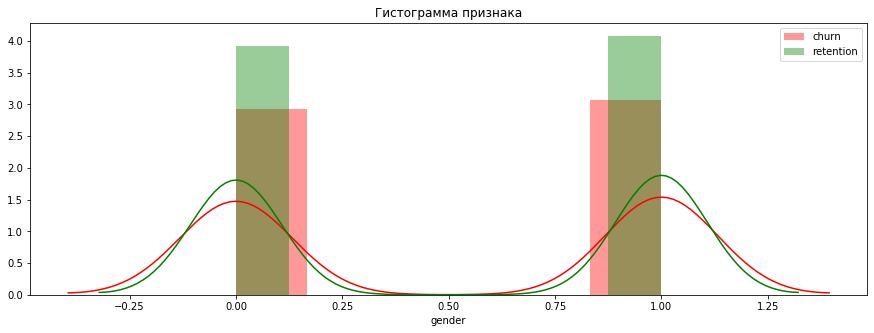

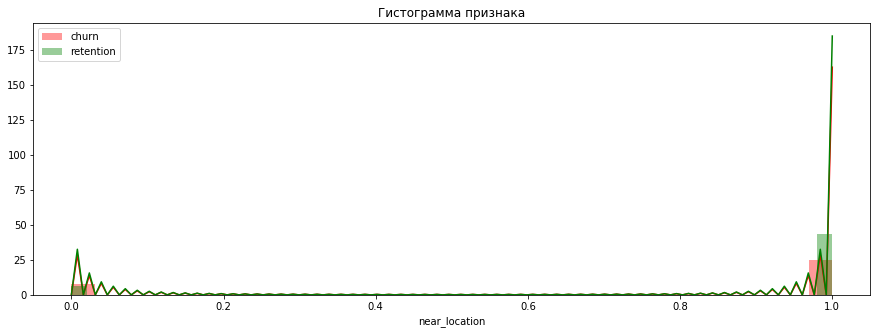

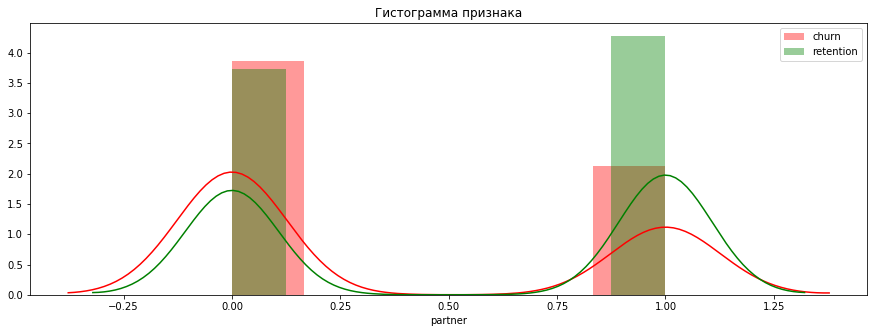

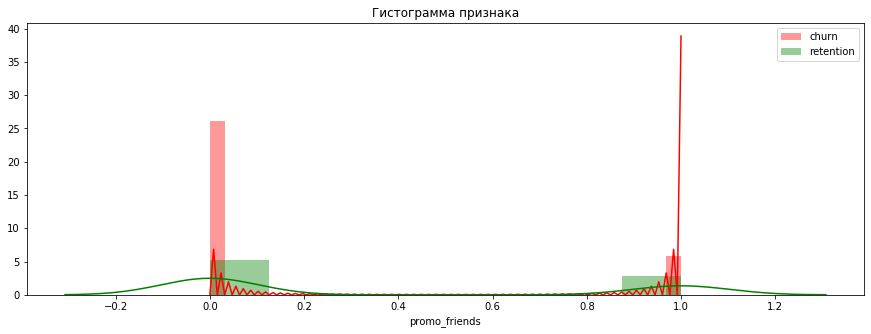

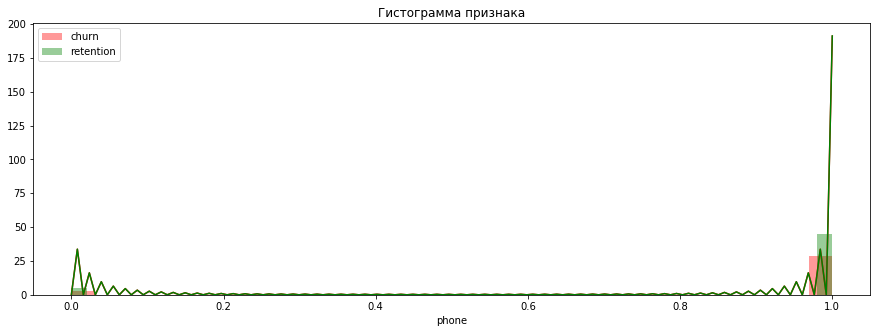

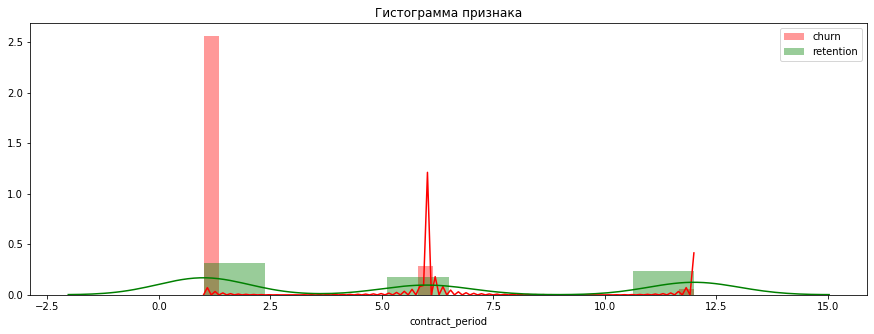

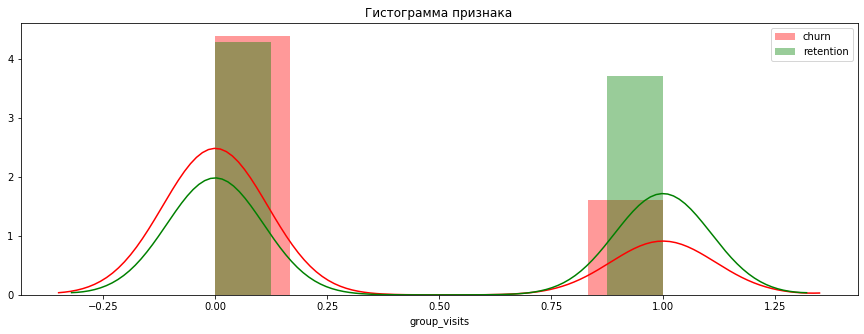

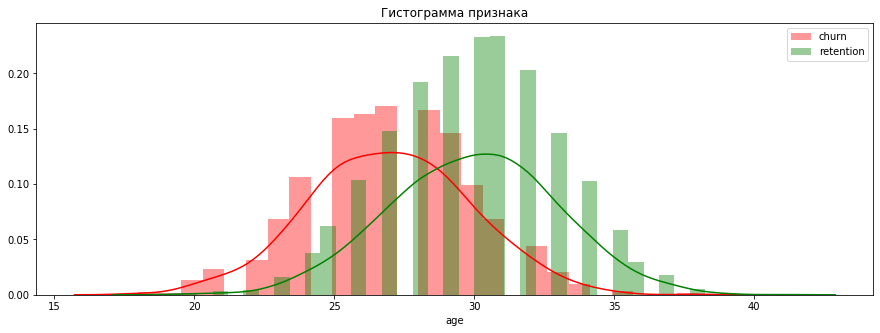

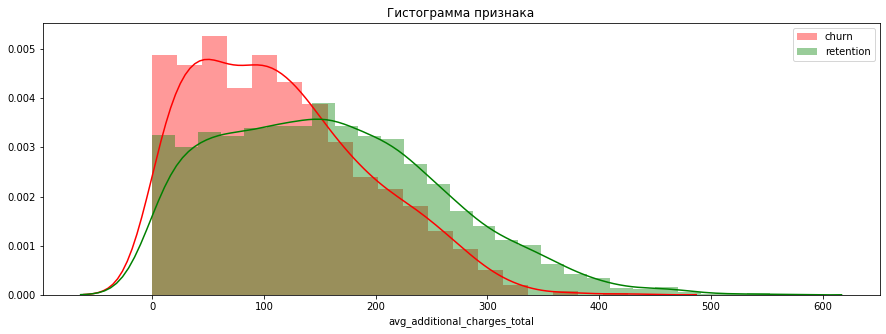

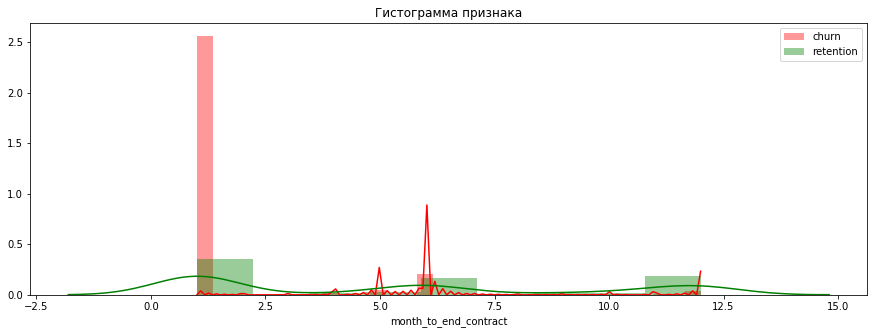

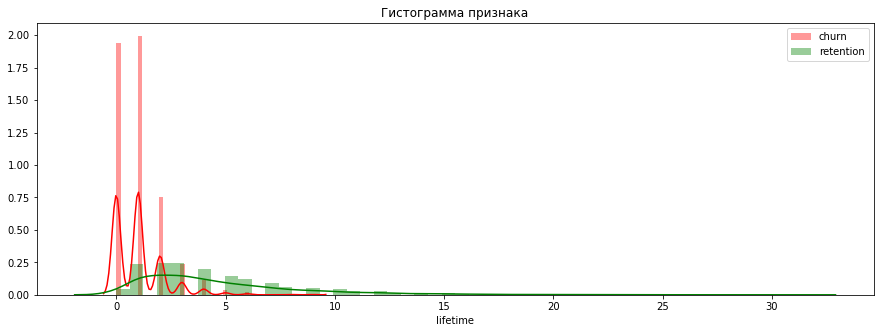

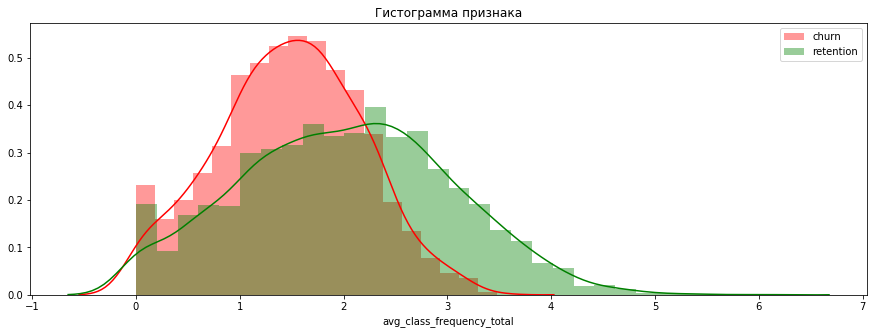

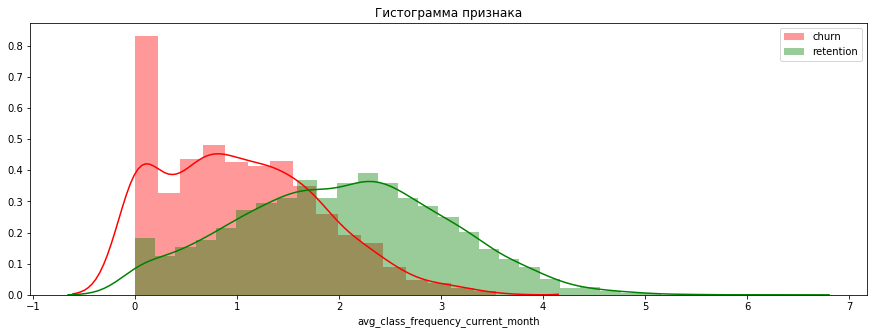

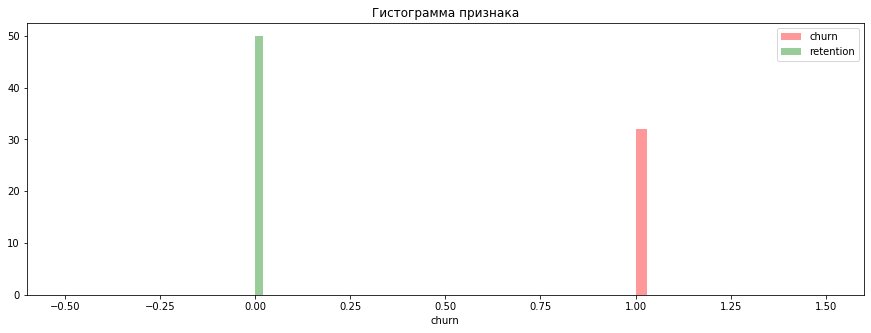

In [11]:
for feature in df.columns:
    sns_hist(churn, retention, feature, 'churn', 'retention')

Графики отлично иллюстрируют выводы, полученные выше.

Построим матрицу корреляции

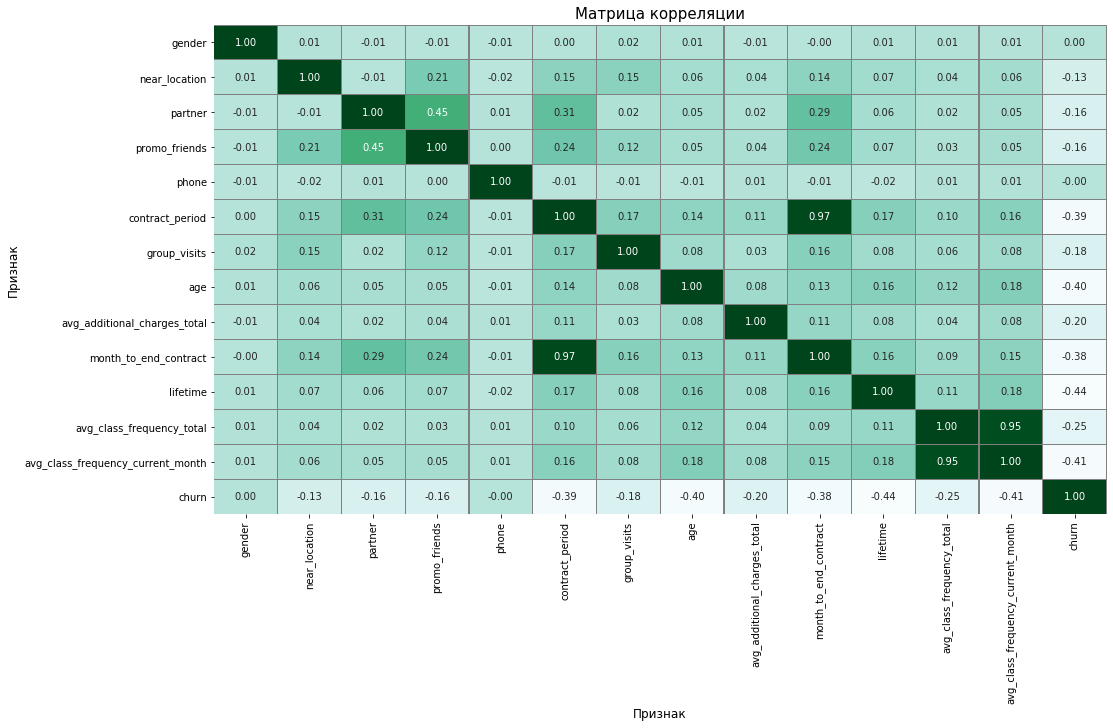

In [12]:
plt.figure(figsize=(16, 9))
sns.heatmap(df.corr(), annot=True, fmt='.2f', linewidths=0.2, linecolor='gray', cmap='BuGn', cbar=False)
plt.title('Матрица корреляции', fontsize = 15)
plt.xlabel('Признак', fontsize = 12, fontweight=500)
plt.ylabel('Признак', fontsize = 12, fontweight=500);

Наиболее заметная корреляция с целевой переменной наблюдается у следующих параметров:  
- *lifetime*,  
- *avg_class_frequency_current_month*,  
- *age*, 
- *contract_period*,  
- *month_to_end_contract*.   

Также можно отметить сильную мультиколлинеарность между следующими признаками:
- *contract_period* и *month_to_end_contract*;
- *avg_class_frequency_current_month* и *avg_class_frequency_total*.

Наличие взаимозависимых признаков в модели может привести к нерепрезентативным весам и её переобучению. Необходимо исключить по одной переменной из каждой пары. Оставим в данных те признаки, которые показали большую корреляцию с целевой переменной: *contract_period* и *avg_class_frequency_current_month*.

In [13]:
df = df.drop('month_to_end_contract', axis=1)

In [14]:
df = df.drop('avg_class_frequency_total', axis=1)

<a name="h4"></a>
### 4. Модель прогнозирования оттока пользователей

Построим модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце (*churn*).

Разделим данные на признаки (матрица *X*) и целевую переменную (*y*)

In [15]:
X = df.drop('churn', axis = 1)
y = df['churn']

Разделим данные на обучающую и валидационную выборку функцией `train_test_split()`

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Построим гистограммы целевой переменной и признаков на обучающей и валидационной выборках, чтобы убедиться в том, что данные были поделены равномерно и однородно.

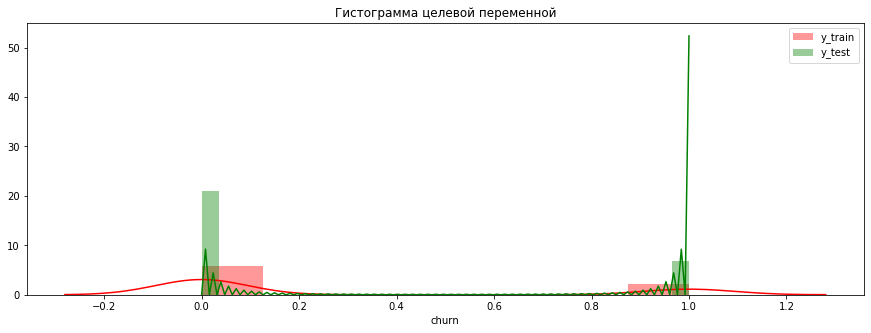

In [17]:
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(y_train, hist=True, kde=True, label='y_train', color = 'red')
sns.distplot(y_test, hist=True, kde=True, label='y_test', color = 'green')
plt.title('Гистограмма целевой переменной')
plt.xlabel(feature)
plt.legend();

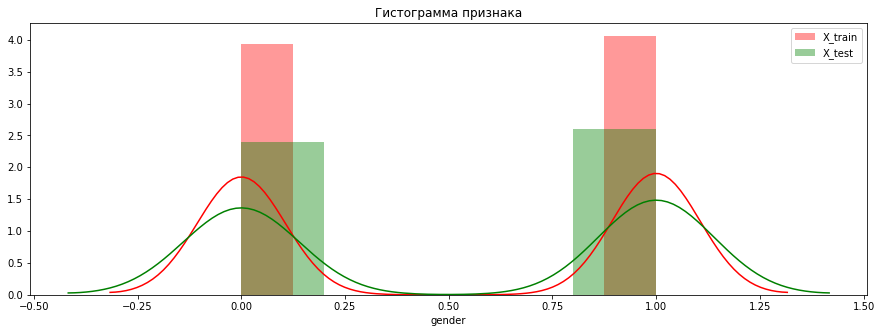

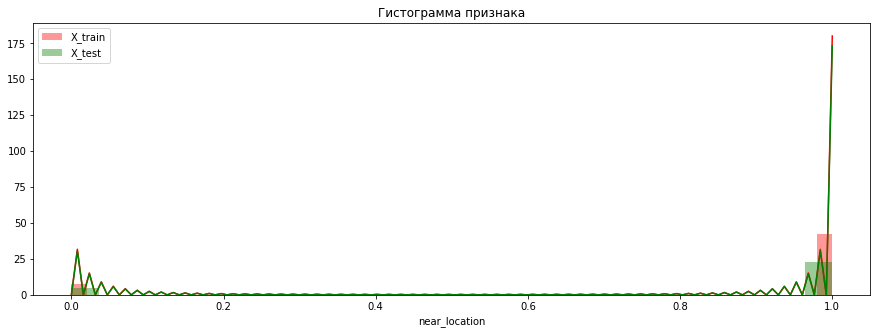

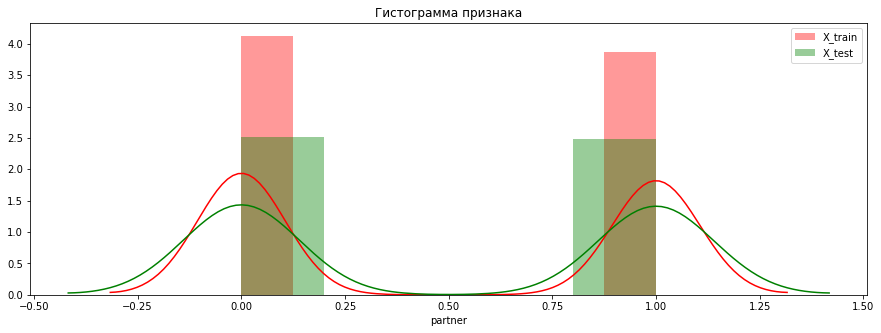

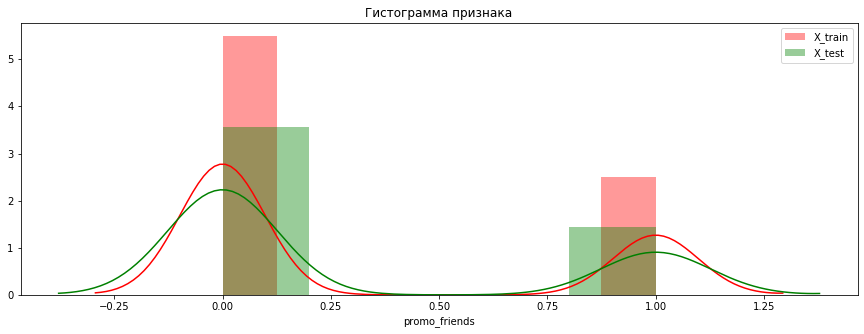

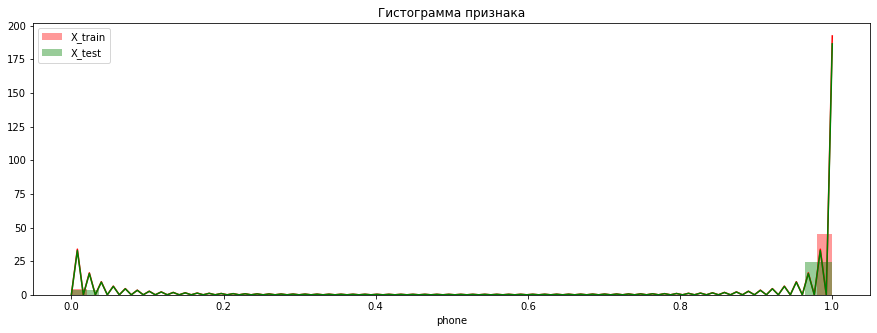

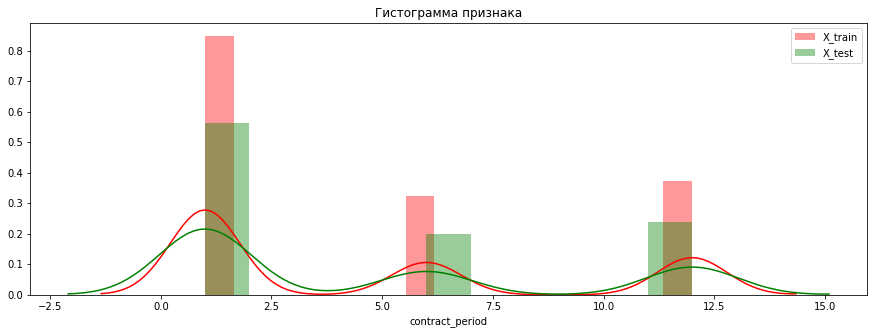

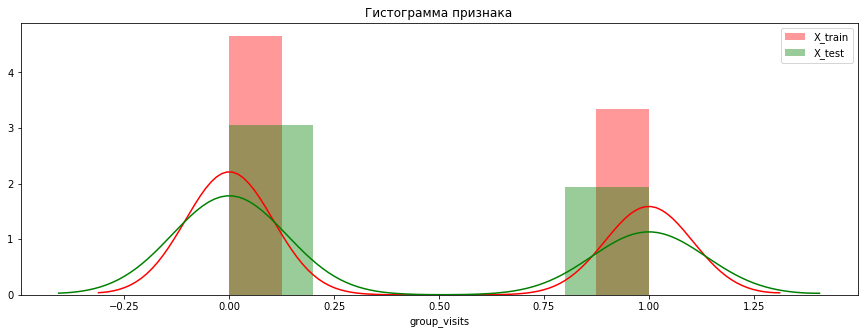

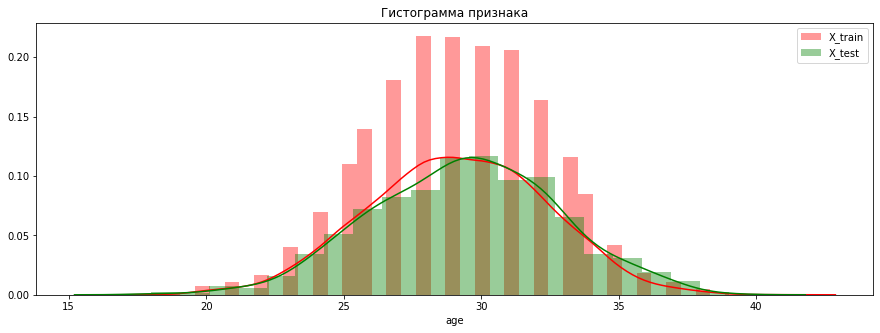

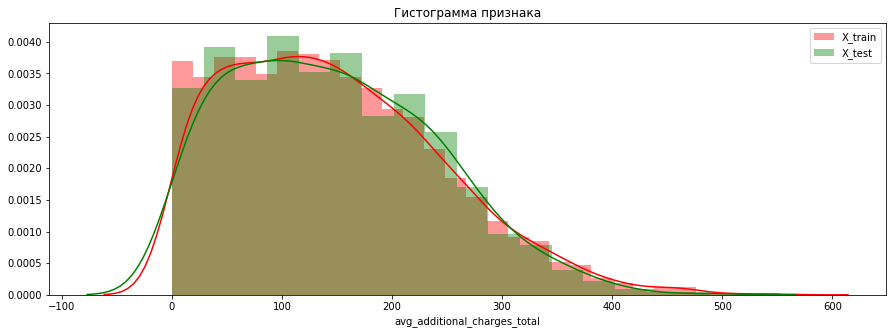

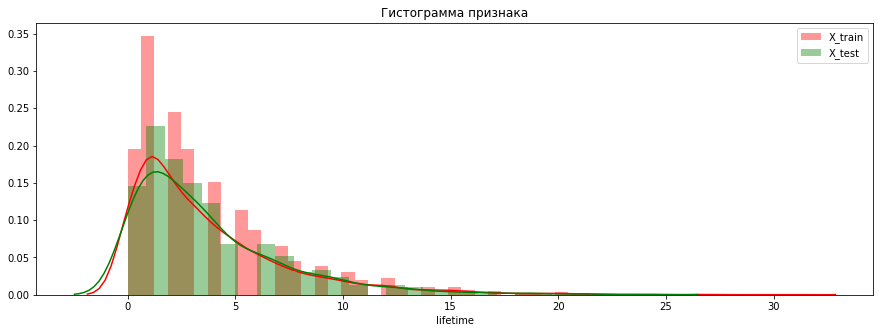

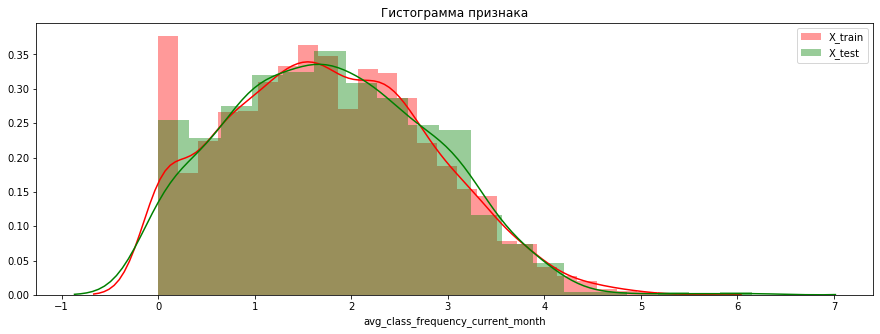

In [18]:
for feature in X_test.columns:
    sns_hist(X_train, X_test, feature, 'X_train', 'X_test')

Распределения test и train похожи, поэтому модель, обученная на train-выборке, должна корректно работать и на тестовой. Можем приступать к обучению.

Обучим модель на train-выборке двумя способами:  
- логистической регрессии;
- случайным лесом.

1. Логистическая регрессия

In [19]:
#задаем алгоритм модели
lr_model = LogisticRegression(random_state = 0, solver='lbfgs', max_iter=400)

In [20]:
#обучаем модель
lr_model.fit(X_train, y_train);

In [21]:
#делаем прогнозы
lr_predictions = lr_model.predict(X_test)
lr_probabilities = lr_model.predict_proba(X_test)[:,1]

Определим основные признаки, наиболее сильно влияющие на отток

In [22]:
[coef] = np.round(lr_model.coef_, 3)

In [23]:
# создадим датафрейм с признаками и их весами
features = pd.DataFrame({'feature': X.columns,
                         'coeff': coef})
features['coeff_abs'] = features['coeff'].abs() 

np.round(features.sort_values(by='coeff_abs', ascending=False), 2)

,feature,coeff,coeff_abs
10,avg_class_frequency_current_month,-1.27,1.27
9,lifetime,-1.09,1.09
6,group_visits,-0.77,0.77
3,promo_friends,-0.54,0.54
7,age,-0.35,0.35
4,phone,-0.32,0.32
5,contract_period,-0.30,0.30
1,near_location,-0.22,0.22
2,partner,-0.12,0.12
0,gender,0.11,0.11


Чем чаще (*avg_class_frequency_current_month*) и дольше (*lifetime*) клиент посещает фитнес-центр, тем выше его лояльность к клубу. Интересные и популярные групповые занятия (*group_visits*) и наличие друзей (*promo_friends*), вместе с которыми можно ходить на тренировки, повышают вероятность того, что клиент продлит абонемент.

2. Случайный лес

Для начала определим оптимальное количество деревьев

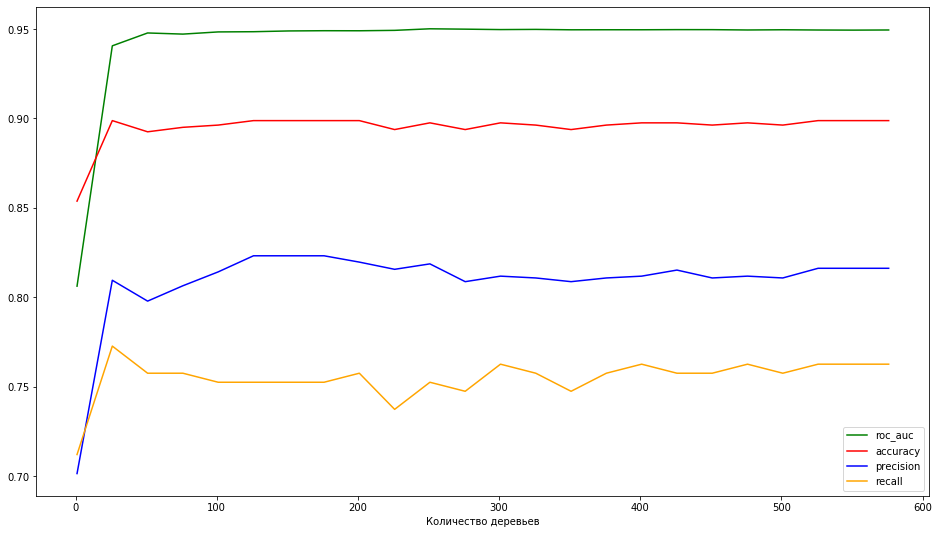

In [24]:
cols = ['n_estimators', 'roc_auc', 'accuracy', 'precision', 'recall']
lst = []
for n in range(1, 600, 25):
    rf_model = RandomForestClassifier(n_estimators = n, random_state = 0)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    rf_probabilities = rf_model.predict_proba(X_test)[:,1]
    
    roc_auc = roc_auc_score(y_test, rf_probabilities)
    accuracy = accuracy_score(y_test, rf_predictions)
    precision = precision_score(y_test, rf_predictions)
    recall = recall_score(y_test, rf_predictions)
    
    lst.append([n, roc_auc, accuracy, precision, recall])
df1 = pd.DataFrame(lst, columns=cols)

plt.figure(figsize=(16,9))
plt.plot(df1['n_estimators'], df1['roc_auc'], label='roc_auc', color='green')
plt.plot(df1['n_estimators'], df1['accuracy'], label='accuracy', color='red')
plt.plot(df1['n_estimators'], df1['precision'], label='precision', color='blue')
plt.plot(df1['n_estimators'], df1['recall'], label='recall', color='orange')
plt.xlabel('Количество деревьев')
plt.legend();

В целом, при количестве деревьев от 100 и выше, показатели достигают относительного плато, хотя показатель `recall` сильнее других подвержен колебаниям. Укажем в качестве параметра количество деревьев равное 600.

In [25]:
#задаем алгоритм модели
rf_model = RandomForestClassifier(n_estimators = 600, random_state = 0)

In [26]:
#обучаем модель
rf_model.fit(X_train, y_train);

In [27]:
#делаем прогнозы
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]

Оценим метрики обеих выборок на валидационной выборке

In [28]:
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [29]:
print_all_metrics(y_test, lr_predictions, lr_probabilities, title = 'Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.82


In [30]:
print_all_metrics(y_test, rf_predictions, rf_probabilities , title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.90
	Precision: 0.82
	Recall: 0.76


Обе модели правильно прогнозируют 90% ответов, однако модель логистической регрессии отличается большей полнотой, в то время как случайный лес характеризуется большей точностью. В целом, метрики модели логистической регрессии чуть лучше, чем у модели случайного леса, однако окончательный выбор модели зависит от целей менеджмента и цены ошибки (как дорого стоит каждое срабатывание модели). 

<a name="h5"></a>
### 5. Кластеризация пользователей

Стандартизируем данные

In [31]:
scaler = StandardScaler() # создаём объект класса scaler
X_sc = scaler.fit_transform(X)

Построим матрицу расстояний функцией `linkage()` и нарисуем дендрограмму

In [32]:
linked = linkage(X_sc, 'ward')

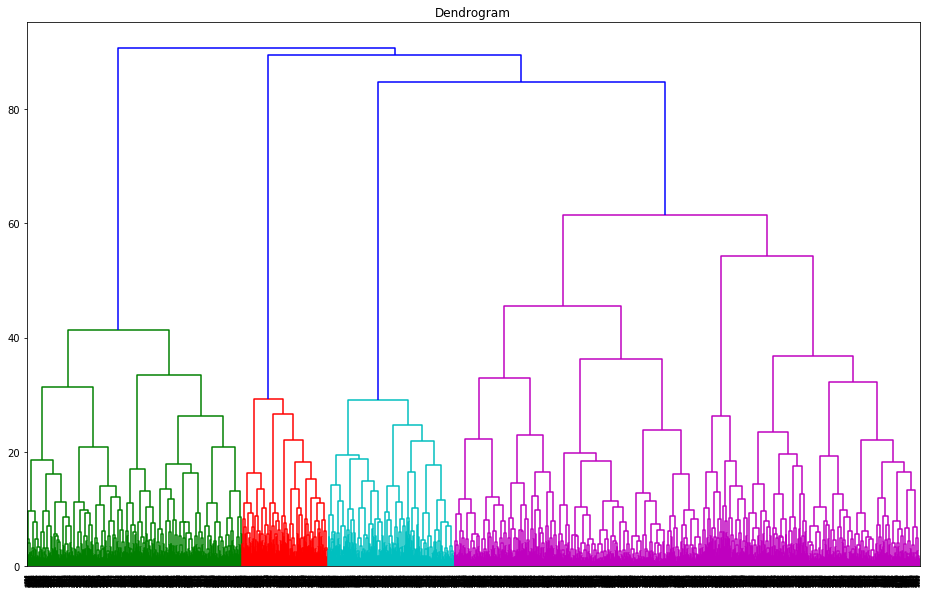

In [33]:
plt.figure(figsize=(16, 10))  
dendrogram(linked, orientation='top')
plt.title('Dendrogram')
plt.show();

Предложенное оптимальное число кластеров 4 — четыре разных цвета на графике.

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов

In [34]:
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(X_sc)

In [35]:
df['cluster'] = labels

Посмотрим на средние значения признаков для кластеров

In [36]:
np.round(df.groupby(['cluster']).mean().T, 2)

cluster,0,1,2,3,4
gender,0.50,0.50,0.50,0.53,0.52
near_location,1.00,0.00,1.00,1.00,0.86
partner,0.89,0.49,0.22,0.38,0.47
promo_friends,1.00,0.08,0.07,0.01,0.31
phone,1.00,1.00,1.00,1.00,0.00
contract_period,6.92,2.99,2.01,6.21,4.78
group_visits,0.52,0.23,0.28,0.54,0.43
age,29.61,28.68,27.58,30.70,29.30
avg_additional_charges_total,153.42,137.13,119.34,176.26,144.21
lifetime,4.28,2.97,1.92,5.42,3.94


Только одна переменная - *gender* - демонстрирует стабильность вне зависимости от принадлежности к тому или иному кластеру, остальные же признаки заметно варьируются от группы к группе.  
`Кластер 0:`
89% участников группы составляют сотрудники компаний-партнёров клуба, при этом практически каждый клиент в данном кластере использовал промо-код от знакомого при оплате первого абонемента. Клиенты данной группы чаще других приобретают абонементы на самый длинный срок - 6-12 месяцев. Они регулярно посещают клуб (в среднем 2 раза в неделю) и групповые занятия (каждый второй член кластера). Скорее всего участники данного кластера чаще других ходят на занятия в компании с кем-то (друзьями или коллегами), что и объясняет неплохие показатели посещаемости клуба.  
`Кластер 1:`
Включает клиентов, которые не живут и не работают в том же районе, где расположен фитнес-клуб. У данного кластера ожидаемо самые низкие показатели участников промо-акции "Приведи друга" и партнерской программы. Клиенты данной группы приобретают  абонементы средней продолжительностью в 3 месяца, занимаются в фитнес-центре 1-2 раза в неделю, но реже других посещают групповые занятия (только каждый четвертый клиент), что обусловлено удаленностью клуба.  
`Кластер 2:`
Претенденты на выбывание. У данного кластера худшие показатели по большинству признаков: они покупают самые короткие абонементы, редко посещают клуб (1, иногда 2 раза в неделю), в частности груповые занятия, приносят меньше выручки по дополнительным услугам, оказываемым фитнес-центром. Все это свидетельствует о низкой степени взаимодействия с клубом, которая может привести к оттоку клиентов.  
`Кластер 3:`
В кластер включены наиболее активные и лояльные клиенты клуба. Клиенты данного кластера дольше других посещают фитнес-центра (показатель *lifetime*) и предпочитают покупать абонементы на более продолжительный срок - средний срок абонемента составляет чуть более 6 месяцев. При этом у данной группы самые высокие показатели по количеству визитов, факту посещения групповых занятий и суммарной выручке от других услуг фитнес-центра.  
`Кластер 4:`
Среднячки. Судя по всему кластер сформировался по признаку *phone* - сюда попали все клиенты, которые не указали номер телефона. Скорее всего, он представляет собой микс из клиентов, которые должны были попасть в другие группы, что частично объясняет усредненность показателей кластера 4, относительно других групп. Вероятно, если бы мы ограничили модель предложенным оптимальным числом кластеров (4), участники именно этой "искусственной" группы распределились бы по другим кластерам.

Разделим выборку по кластерам

In [37]:
cluster_0 = df.query('cluster == 0')
cluster_1 = df.query('cluster == 1')
cluster_2 = df.query('cluster == 2')
cluster_3 = df.query('cluster == 3')
cluster_4 = df.query('cluster == 4')

Создадим функцию для построения гистограм по кластерам

In [38]:
def sns_hist_2(df1, df2, df3, df4, df5, feature, label1, label2, label3, label4, label5):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.distplot(df1[feature], hist=True, kde=True,
             label=label1,
             color = 'red')
    sns.distplot(df2[feature], hist=True, kde=True,
             label=label2,
             color = 'orange')
    sns.distplot(df3[feature], hist=True, kde=True,
             label=label3,
             color = 'green')
    sns.distplot(df4[feature], hist=True, kde=True,
             label=label4,
             color = 'blue')
    sns.distplot(df5[feature], hist=True, kde=True,
             label=label5,
             color = 'grey')
    
    plt.title('Гистограмма признака')
    plt.xlabel(feature)
    plt.legend();

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


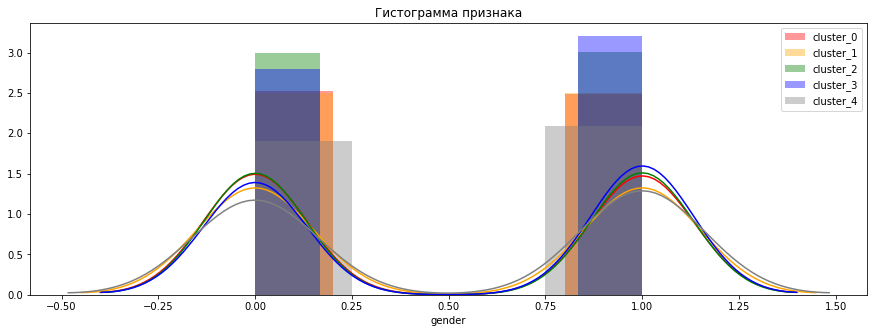

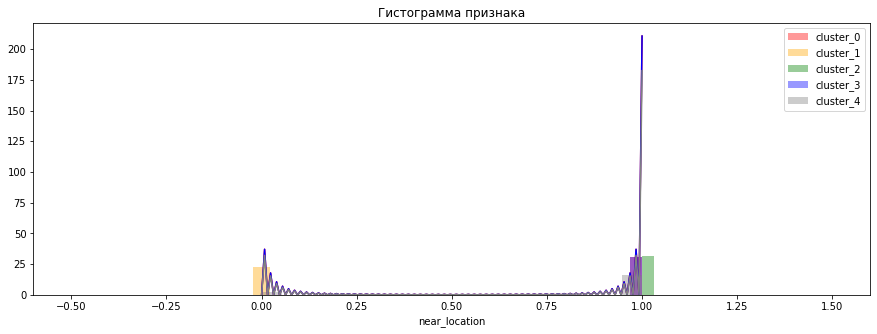

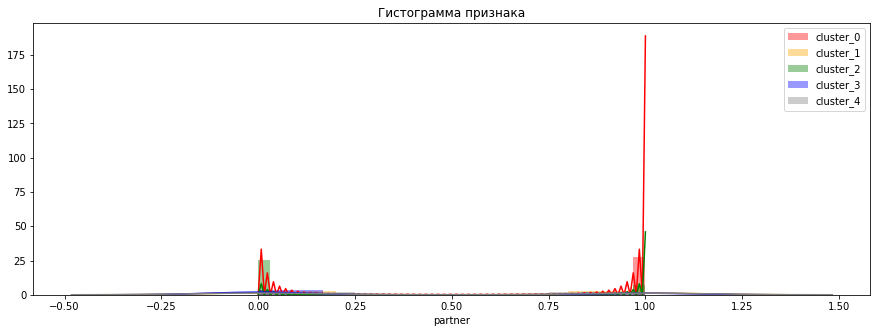

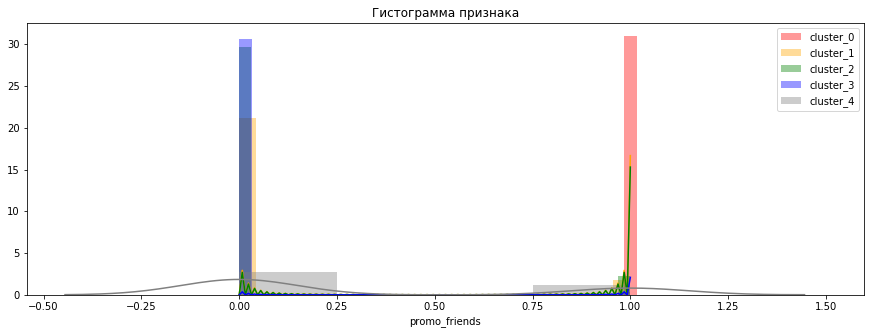

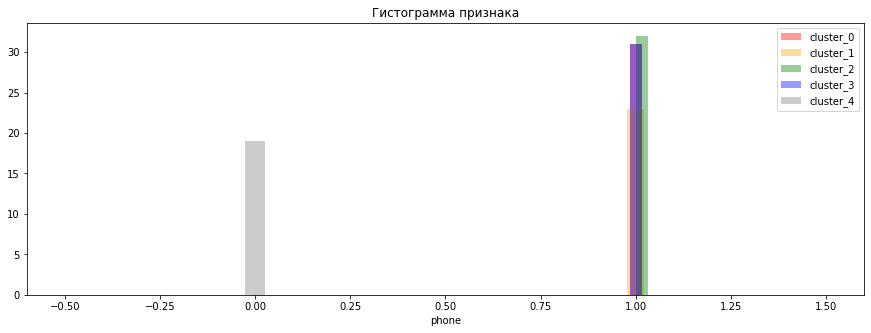

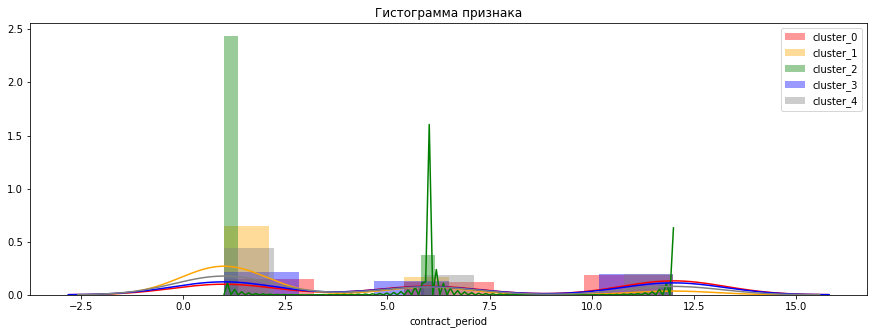

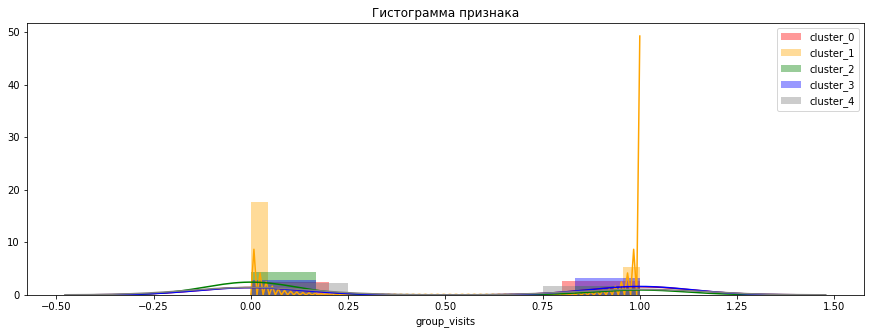

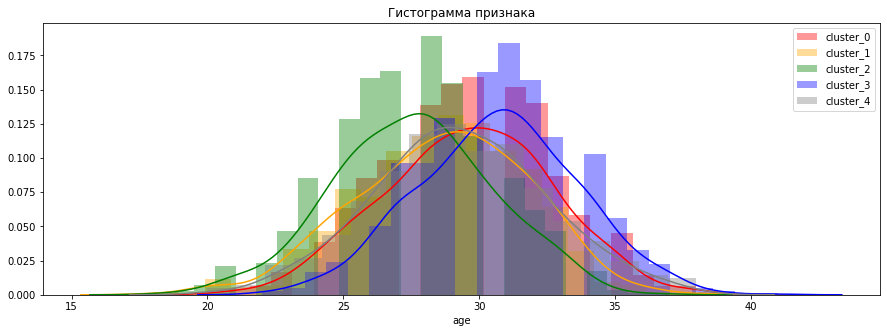

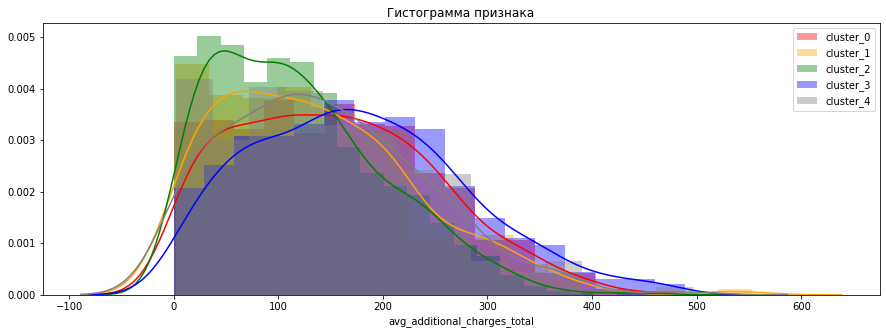

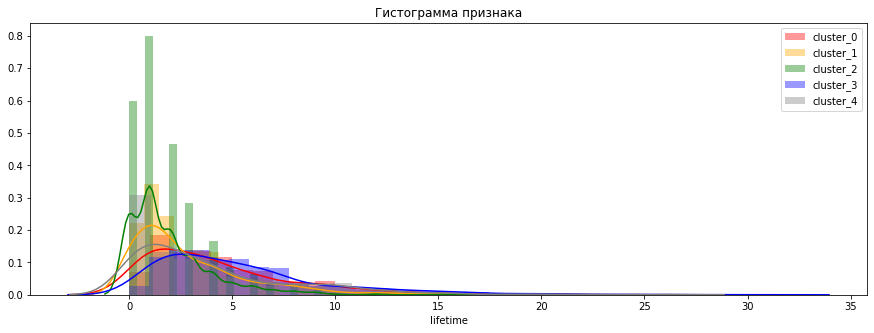

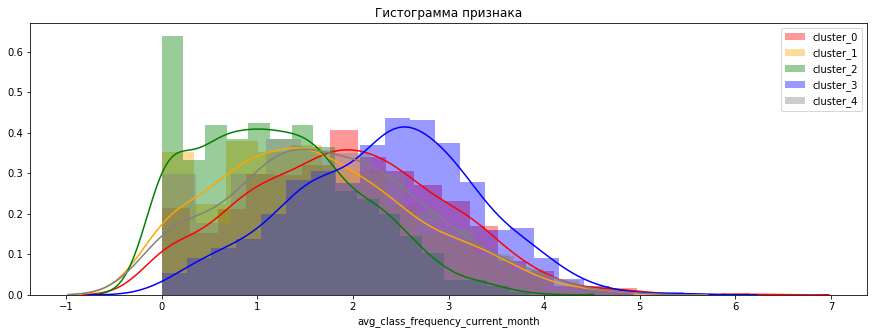

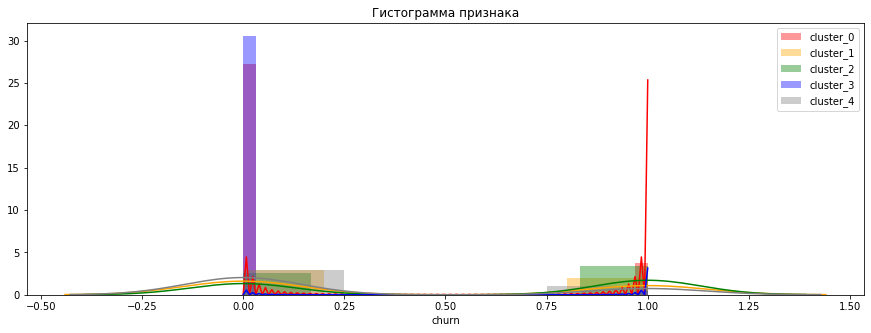

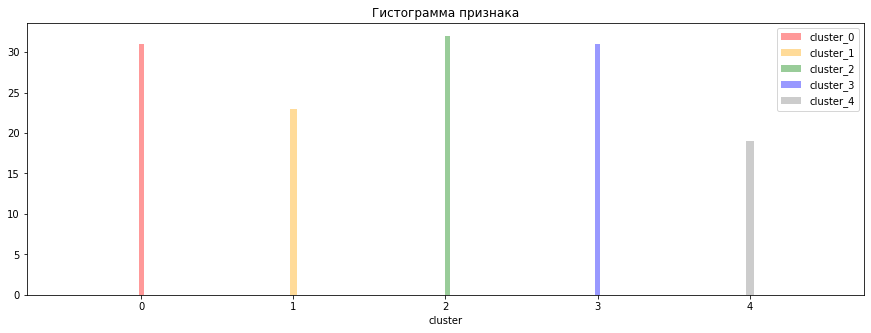

In [39]:
for feature in df.columns:
    sns_hist_2(cluster_0, cluster_1, cluster_2, cluster_3, cluster_4, feature, 
               'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4')

Полученные графики подтверждают выводы, сделанные выше.

Для каждого выделенного кластера посчитаем долю оттока методом `groupby()`

In [40]:
df.groupby(['cluster']).agg({'churn':'mean'}).T

cluster,0,1,2,3,4
churn,0.12,0.4,0.56,0.01,0.27


Доля будущих бывших посетителей фитнес-центра существенно меняется от кластера к кластеру. В кластере 2, как и ожидалось, каждый второй клиент попадет в отток в следующем месяце, а в кластере 1 двое из пяти клиентов перестанут посещать клуб по причине его удаленности. Самыми лояльными являются посетители из кластера 3 - доля ушедших в следующем месяце составила всего 1% от всех клиентов группы.



<a name="h6"></a>
### 6. Выводы и рекомендации

В ходе данного исследования были изучены данные 4 000 клиентов сети фитнес-центров «Культурист-датасаентист». Анализ показал, что чем регулярнее и дольше клиент посещает фитнес-центр, тем выше его лояльность к клубу. Интересные и популярные групповые занятия и наличие друзей/коллег, вместе с которыми можно ходить на тренировки, повышают вероятность того, что клиент продлит абонемент.  

В рамках исследования были определены 4 ярко-выраженные группы посетителей, для каждой из которых будут наиболее актуальны свои меры по снижению оттока:  

*1. Активные посетители клуба, занимающиеся на протяжении долгого времени*  
Лояльность к клубу у таких клиентов уже сформировалась и теперь ее необходимо только поддерживать. Например, можно разработать программу лояльности, согласно которой клиент получает определенные бонусы за «стаж» членства в фитнес-клубе и активность: посещение платных тренировок, участие в опросах, рекомендацию клуба друзьям. Заработанные баллы могут быть потрачены на дополнительные услуги клуба или предоставлены в виде скидки на продление абонемента.

*2. Клиенты, привлеченные в клуб благодаря промо-акции "Приведи друга"*  
Скорее всего такие клиенты предпочитают ходить на занятия в компании с кем-то, поэтому для них будут интересны специальные предложения на парные абонементы и тренировки.

*3. Клиенты, проживающие/работающие в удалении от фитнес-центра*  
Таким клиентам гораздо сложнее заставить себя прийти в фитнес-центр, поэтому отток среди них очень высок - 40%. Для того чтобы повысить их мотивацию и интерес к клубу, можно предложить им интересующие их групповые занятия в максимально удобное для них время. Также их может заинтересовать возможность приобретения абонементов по сниженной цене, но действующих только в определенные часы. Ввиду территориальной удаленности такие посетители, скорее всего, заранее планируют время визита и редко приходят на занятия спонтанно.

*4. Клиенты, которые практически не посещают фитнес-клуб*  
Наиболее уязвимая группа, больше половины участников которой перестанут посещать клуб в следующем месяце. Для того, чтобы удержать таких клиентов, необходимо повысить их взаимодействие с клубом: интересные и разнообразные групповые тренировки, проведение различных конкурсов, марафонов и соревнований могут повысить их мотивацию и интерес. 

